In [2]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install ipywidgets

  Using cached transformers-4.15.0-py3-none-any.whl (3.4 MB)
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached regex-2021.11.10-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (748 kB)
  Using cached tokenizers-0.10.3-cp36-cp36m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Using cached filelock-3.4.1-py3-none-any.whl (9.9 kB)
  Using cached sacremoses-0.0.47-py2.py3-none-any.whl (895 kB)
  Using cached sentencepiece-0.1.96-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached nltk-3.6.7-py3-none-any.whl (1.5 MB)
  Using cached ipywidgets-7.6.5-py2.py3-none-any.whl (121 kB)
  Using cached jupyterlab_widgets-1.0.2-py3-none-any.whl (243 kB)
  Using cached widgetsnbextension-3.5.2-py2.py3-none-any.whl (1.6 MB)
  Using cached nbformat-5.1.3-py3-none-any.whl (178 kB)
  Using cached jedi-0.17.2-py2.py3-none-any.whl (1.4 MB)
  Using cached parso-0.7.1-py2.py3-none-any.whl (109 k

In [50]:
import pandas as pd
import numpy as np
import random
import joblib
import torch

from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders

from DataAugmentation import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from seqeval.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef,classification_report,f1_score
import engine
# from model_new import EntityModel
import torch.nn as nn
from tqdm import tqdm

In [5]:
# Read the data
def process_data(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,model_type):
    
    dataObj = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df= dataObj.createDf() # get dataframe from files
    obj_tokenized = createTokenizedDf(df,model_type)
    df_new= obj_tokenized.convertDf()
    train_data = CompDataset(df_new,model_type)
    return train_data


In [6]:
#loading dev/eval data
dataset_eval = process_data(config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,config.filePath_tarTags_eval,model_type = 'xlm')
len(dataset_eval)

1000

In [7]:
dataObj = loadDatafromFile(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags)
df= dataObj.createDf() 
df
# list(df.source)

,source,target,src_tokens,tar_tokens
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,OK OK OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
1,"However , a disappointing ninth in China meant...",Eine enttäuschende Neunte in China bedeutete j...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...,OK BAD OK BAD OK BAD OK OK OK OK OK OK OK OK O...
2,"In his diary , Chase wrote that the release of...","In seinem Tagebuch , Chase schrieb , dass die ...",OK OK OK OK BAD BAD OK OK OK OK OK OK OK OK BA...,OK OK OK OK OK OK OK OK OK BAD OK BAD OK OK OK...
3,Heavy arquebuses mounted on wagons were called...,Schwere Arquebuses auf Waggons montiert wurden...,OK BAD BAD OK OK OK OK OK OK OK OK,OK OK OK BAD OK OK OK OK BAD BAD OK OK OK OK O...
4,Once North Pacific salmon die off after spawni...,Sobald der nordpazifische Lachs nach dem Laich...,OK OK OK OK BAD OK OK OK OK OK BAD OK BAD OK O...,OK OK OK BAD OK OK OK BAD OK OK OK OK OK OK OK...
...,...,...,...,...
6995,Some may also discourage or disallow unsanitar...,Einige können auch unhygienische Praktiken wie...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
6996,"In the late 1860s , the crinolines disappeared...",In den späten 1860er Jahren verschwanden die K...,OK OK OK OK OK OK OK OK OK OK BAD BAD OK OK OK...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
6997,"Disco was criticized as mindless , consumerist...","Disco wurde als geistlos , konsumistisch , übe...",OK OK OK OK BAD OK BAD OK OK OK OK OK,OK OK OK OK OK OK OK BAD OK OK OK BAD OK OK OK...
6998,Planters would then fill large hogsheads with ...,Die Pflanzer würden dann große Heuschrecken mi...,OK OK OK BAD OK BAD OK OK BAD BAD OK OK OK OK OK,OK OK OK OK OK BAD OK OK OK OK OK BAD OK OK OK...


In [12]:
import DataAugmentation
DataAugmentation = reload(DataAugmentation)
from DataAugmentation import DataAugmentation

In [8]:
dataaug_obj = DataAugmentation(df,swap_words=2,syn_words=3,del_words_prob=0.2,num_sentences=2)  
swapDataset = dataaug_obj.random_swap()
del_augDataset = dataaug_obj.random_deletion()
del_augDataset = del_augDataset[7000:]
syn_dataset = dataaug_obj.synonym_replacement()
syn_dataset = syn_dataset[7000:]
frames = [swapDataset , del_augDataset,syn_dataset]
aug_df  = pd.concat(frames)
aug_df

,source,target,src_tokens,tar_tokens
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,OK OK OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
1,"However , a disappointing ninth in China meant...",Eine enttäuschende Neunte in China bedeutete j...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...,OK BAD OK BAD OK BAD OK OK OK OK OK OK OK OK O...
2,"In his diary , Chase wrote that the release of...","In seinem Tagebuch , Chase schrieb , dass die ...",OK OK OK OK BAD BAD OK OK OK OK OK OK OK OK BA...,OK OK OK OK OK OK OK OK OK BAD OK BAD OK OK OK...
3,Heavy arquebuses mounted on wagons were called...,Schwere Arquebuses auf Waggons montiert wurden...,OK BAD BAD OK OK OK OK OK OK OK OK,OK OK OK BAD OK OK OK OK BAD BAD OK OK OK OK O...
4,Once North Pacific salmon die off after spawni...,Sobald der nordpazifische Lachs nach dem Laich...,OK OK OK OK BAD OK OK OK OK OK BAD OK BAD OK O...,OK OK OK BAD OK OK OK BAD OK OK OK OK OK OK OK...
...,...,...,...,...
20995,"discotheque was criticized as asinine , consum...","Disco wurde als geistlos , konsumistisch , übe...",OK OK OK OK BAD OK BAD OK OK OK OK OK,OK OK OK OK OK OK OK BAD OK OK OK BAD OK OK OK...
20996,Planters would then fulfill enceinte hogshead ...,Die Pflanzer würden dann große Heuschrecken mi...,OK OK OK BAD OK BAD OK OK BAD BAD OK OK OK OK OK,OK OK OK OK OK BAD OK OK OK OK OK BAD OK OK OK...
20997,plantation owner would then fill expectant hog...,Die Pflanzer würden dann große Heuschrecken mi...,OK OK OK OK BAD OK BAD OK OK BAD BAD OK OK OK ...,OK OK OK OK OK BAD OK OK OK OK OK BAD OK OK OK...
20998,He slew Krishna 's most life threatening enemy...,Er tötete Krishnas gefährlichsten Feind Jarasa...,OK OK OK OK OK OK OK OK OK OK OK OK OK BAD OK ...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...


In [9]:
aug_df.iloc[20995:].values

array([['Disco was criticized and . , consumerist , overproduced as escapist mindless',
        'Disco wurde als geistlos , konsumistisch , überproduziert und entflohen kritisiert .',
        'OK OK OK OK OK OK BAD OK OK OK OK BAD',
        'OK OK OK OK OK OK OK BAD OK OK OK BAD OK OK OK OK OK OK OK BAD OK OK OK OK OK'],
       ['Planters would then fill warehouses hogsheads with inspection and convey them to tobacco large .',
        'Die Pflanzer würden dann große Heuschrecken mit Tabak füllen und sie in Inspektionslager transportieren .',
        'OK OK OK BAD OK BAD OK OK BAD BAD OK OK OK OK OK',
        'OK OK OK OK OK BAD OK OK OK OK OK BAD OK OK OK OK OK BAD OK BAD OK OK OK OK OK OK OK BAD OK OK OK'],
       ['Planters would then fill large hogsheads with to tobacco convey them and inspection warehouses .',
        'Die Pflanzer würden dann große Heuschrecken mit Tabak füllen und sie in Inspektionslager transportieren .',
        'OK OK OK BAD OK BAD OK OK OK BAD OK BAD OK OK OK

In [11]:
aug_df =aug_df.sample(frac=1).reset_index(drop=True)
aug_df

,source,target,src_tokens,tar_tokens
0,From 30 June to 2 July 1967 The the Empire Pool .,Vom 30. Juni bis 2. Juli 1967 spielten die Mon...,OK OK OK OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
1,general Sir Edmund Ironside of the British uni...,General Sir Edmund Ironside der Britischen Arm...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
2,Doc Kuhn returned a 80 yards .,Kapitän Doc Kuhn gab einmal einen Kickoff 80 M...,OK OK OK OK OK OK OK,OK OK OK OK OK OK OK BAD OK OK OK OK OK OK OK ...
3,Differences in dimensionalities of phonons and...,Unterschiede in der Dimensionalität von Phonen...,OK OK BAD OK BAD OK BAD OK OK OK OK BAD OK OK ...,OK OK OK OK OK BAD OK BAD OK OK OK BAD OK OK O...
4,This initiated a rivalry between Carreras and ...,Dies löste eine Rivalität zwischen Carreras un...,OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
...,...,...,...,...
48995,The Gargoyle Club opened No 69 Dean Street in ...,Der Gargoyle Club wurde 1925 in der No 69 Dean...,OK OK OK OK BAD BAD BAD BAD OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK B...
48996,After a defensive stop by the Gators on the en...,Nach einem defensiven Stopp der Gators auf dem...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK BAD ...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
48997,play Iowa Wells The in the Indoor Football Lea...,Die Iowa Barnstormers spielen in der Indoor Fo...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
48998,Experience such against or gained as the Zulus...,Erfahrungen gegen Feinde wie Zulus oder Sudane...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...


In [19]:
import data_utils
data_utils=reload(data_utils)
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders


In [9]:
obj_tokenized = createTokenizedDf(aug_df,model_type = 'xlm')
df_new= obj_tokenized.convertDf()
# enc_label = preprocessing.LabelEncoder()
# df_new['labels']= enc_label.fit_transform(df_new['labels'])
train_data = CompDataset(df_new, model_type = 'xlm')

In [10]:
print(len(train_data))
train_data[0]

49000


(tensor([     0,  17151,  12426,   2765,    113,    527, 110896,  36997,     71,
          20387,   2189,    141,     99, 183124,     23,  58020,      6,      5,
              2,      2,    656,  58020,    656, 138438,     13,    656,  17151,
            656,  12426,   2765,    656,    113,    656,    527, 110896,    656,
          20387,   2189,    141,    656,     23,    656, 183124,    656,      6,
              5,    656,      2,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [12]:
# dataloaders
loader_obj = createDataloaders(train_data,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
len(train_dataloader)

3063

In [13]:
loader_obj = createDataloaders(dataset_eval,config.VALID_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()
len(val_dataloader)

125

In [14]:
batch = next(iter(val_dataloader))
batch[0][0]

[2022-01-11 17:53:43.814 pytorch-1-6-gpu-py-ml-g4dn-4xlarge-2e6810ebbda9b4b388820237068d:31 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-11 17:53:43.848 pytorch-1-6-gpu-py-ml-g4dn-4xlarge-2e6810ebbda9b4b388820237068d:31 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


tensor([     0,    581,    799,    147, 156615,  35060,     71,    111,     70,
             6, 245338,  92442,  18481,      7,  40494,   1218,   3331,   3767,
           192,  12960,     70, 218516, 132556,  82122,     71,     47,     70,
           717,  11230,  18481,      7,      6,      5,      2,      2,    656,
           622,    656,   7473,     76,   1106,    656, 240157,    656,  88731,
            33,    656,   1312,    656,    168,    656,      6, 245338,  92442,
             9,   4153,   1428,     19,    656,    491,    656, 163305,    656,
           542,    656,   1218,   3331,   3767,    192,    656,      6,      4,
           656,  31005,    656,     68,    656, 218516,    656, 132556,    656,
           168,    656,    717,  11230,      9,   4153,   1428,     19,    656,
            22,     18, 105038,     19,    656,      6,      5,    656,      2,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [15]:
def loss_fn(output,target,mask):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    active_logits = output.view(-1,2)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)    
    )
    loss = lfn(active_logits,active_labels)
    return loss

In [15]:
class EntityModel(nn.Module):
    
    def __init__(self):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaForTokenClassification.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
#         self.bert_drop_1 = nn.Dropout(0.3)
#         self.out_tag = nn.Linear(768, 2)
    
    def forward(self, ids, attention_mask, labels):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                labels = labels,return_dict=False)
#         bo_tag = self.bert_drop_1(output_1)
        
#         tag = self.out_tag(bo_tag)  
        
#         loss_tag = loss_fn(outputs[1],labels,attention_mask)
        
#         return bo_tag,loss
        return outputs[0], outputs[1]
        

In [23]:
# b_input_ids = batch[0].cuda()
# b_input_mask = batch[1].cuda()
# b_labels = batch[2].cuda()
# outputs = model(b_input_ids, 
#                 b_input_mask,
#                 labels=b_labels)

In [16]:
model = EntityModel()
model.cuda()
# model = nn.DataParallel(model)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

EntityModel(
  (bert): XLMRobertaForTokenClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_

In [23]:
# print(model)

In [38]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()
# outputs[0]

In [17]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = 0
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best 
            if mode == 'max':
                self.is_better = lambda a, best: a > best 
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [18]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(swapDataset) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=4)

In [19]:
config.EPOCHS

20

In [40]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(val_dataloader, model)
print(classification_report(labels_test,preds_test)) # validation data

100%|██████████| 125/125 [00:13<00:00,  9.13it/s]


Average F1 Validation score for class 0 : 0.0
Average F1 Validation score for class 1 : 0.9294044211680166
Average Accuracy Validation score  : 0.8681190540521324
Average mcc Validation score  : 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9274
           1       0.87      1.00      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.43      0.50      0.46     70321
weighted avg       0.75      0.87      0.81     70321



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted 

In [20]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(train_dataloader, model)
print(classification_report(labels_test,preds_test))

100%|██████████| 3063/3063 [10:28<00:00,  4.87it/s]


Average F1 Validation score for class 0 : 0.22551963764400193
Average F1 Validation score for class 1 : 0.26909471780131133
Average Accuracy Validation score  : 0.24793784256843363
Average mcc Validation score  : 0.026086630032881686
              precision    recall  f1-score   support

           0       0.13      0.87      0.23    424348
           1       0.89      0.16      0.27   2947606

    accuracy                           0.25   3371954
   macro avg       0.51      0.51      0.25   3371954
weighted avg       0.80      0.25      0.26   3371954



In [30]:
config = reload(config)

In [21]:
for name,param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True

In [ ]:

best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta__DataAugmentation_Combined.txt', 'w') as f:
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[5],train_metrics[6]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[5],test_metrics[6]))
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            train_loss_lst.append(train_metrics[:-2])
            val_loss_lst.append(test_metrics[:-2])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            if early_stopping.step(test_metrics[4]): #mcc score for early stopping
                  break  # early stop criterion is met, we can stop now
            if test_metrics[4] >  best_accuracy:
                torch.save(model.state_dict(), './models/training_data/model_xlmrobertatokenclassificationmodel_DataAugmentationSwap_Combined.bin')
                best_accuracy = test_metrics[4]

Epoch 1 of 20


100%|██████████| 3063/3063 [36:28<00:00,  1.40it/s]


Average F1 Training score for class 0 : 0.44637852143037887
Average F1 Training score for class 1 : 0.943905052325835
Average Accuracy Training score  : 0.8981317657358315
Average mcc Training score  : 0.43476314422520795


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.71      0.33      0.45    424348
           1       0.91      0.98      0.94   2947606

    accuracy                           0.90   3371954
   macro avg       0.81      0.65      0.70   3371954
weighted avg       0.88      0.90      0.88   3371954



100%|██████████| 125/125 [00:12<00:00,  9.70it/s]


Average F1 Validation score for class 0 : 0.29780033840947545
Average F1 Validation score for class 1 : 0.9320367149909149
Average Accuracy Validation score  : 0.8760683152969952
Average mcc Validation score  : 0.29198863762559113
              precision    recall  f1-score   support

           0       0.59      0.20      0.30      9274
           1       0.89      0.98      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.74      0.59      0.61     70321
weighted avg       0.85      0.88      0.85     70321

Train Loss = 0.25785257711573595 Valid Loss = 0.4580139534473419
Epoch 2 of 20


100%|██████████| 3063/3063 [36:26<00:00,  1.40it/s]


Average F1 Training score for class 0 : 0.7690198367868903
Average F1 Training score for class 1 : 0.9692924880933382
Average Accuracy Training score  : 0.9457916685696187
Average mcc Training score  : 0.7409921105175994


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.72      0.77    424348
           1       0.96      0.98      0.97   2947606

    accuracy                           0.95   3371954
   macro avg       0.89      0.85      0.87   3371954
weighted avg       0.94      0.95      0.94   3371954



100%|██████████| 125/125 [00:13<00:00,  9.61it/s]


Average F1 Validation score for class 0 : 0.3594049197230815
Average F1 Validation score for class 1 : 0.9315463073726626
Average Accuracy Validation score  : 0.876310063850059
Average mcc Validation score  : 0.3282844571861106
              precision    recall  f1-score   support

           0       0.57      0.26      0.36      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.73      0.62      0.65     70321
weighted avg       0.85      0.88      0.86     70321

Train Loss = 0.1376311779460057 Valid Loss = 0.6347898162603378
Epoch 3 of 20


100%|██████████| 3063/3063 [36:36<00:00,  1.39it/s]


Average F1 Training score for class 0 : 0.8631392212412543
Average F1 Training score for class 1 : 0.9809169191737435
Average Accuracy Training score  : 0.9665042880181639
Average mcc Training score  : 0.8445157313312648


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.84      0.86    424348
           1       0.98      0.98      0.98   2947606

    accuracy                           0.97   3371954
   macro avg       0.93      0.91      0.92   3371954
weighted avg       0.97      0.97      0.97   3371954



100%|██████████| 125/125 [00:13<00:00,  9.55it/s]


Average F1 Validation score for class 0 : 0.36357132637001005
Average F1 Validation score for class 1 : 0.9297669424619465
Average Accuracy Validation score  : 0.8734944042320217
Average mcc Validation score  : 0.32308861484779705
              precision    recall  f1-score   support

           0       0.54      0.27      0.36      9274
           1       0.90      0.96      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.62      0.65     70321
weighted avg       0.85      0.87      0.86     70321

Train Loss = 0.08525214576865679 Valid Loss = 0.7257872706651688
Epoch 4 of 20


100%|██████████| 3063/3063 [36:23<00:00,  1.40it/s]


Average F1 Training score for class 0 : 0.9123825749227096
Average F1 Training score for class 1 : 0.9875446753457466
Average Accuracy Training score  : 0.978189797369715
Average mcc Training score  : 0.9000015555391689


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.90      0.91    424348
           1       0.99      0.99      0.99   2947606

    accuracy                           0.98   3371954
   macro avg       0.95      0.95      0.95   3371954
weighted avg       0.98      0.98      0.98   3371954



100%|██████████| 125/125 [00:13<00:00,  9.39it/s]


Average F1 Validation score for class 0 : 0.34516058233960056
Average F1 Validation score for class 1 : 0.9295046978491489
Average Accuracy Validation score  : 0.8727122765603447
Average mcc Validation score  : 0.3089448943752103
              precision    recall  f1-score   support

           0       0.54      0.25      0.35      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.61      0.64     70321
weighted avg       0.85      0.87      0.85     70321

Train Loss = 0.055916349867245085 Valid Loss = 0.8554777417182923
Epoch 5 of 20


100%|██████████| 3063/3063 [36:27<00:00,  1.40it/s]


Average F1 Training score for class 0 : 0.9427086541058087
Average F1 Training score for class 1 : 0.991800788935913
Average Accuracy Training score  : 0.9856546085741383
Average mcc Training score  : 0.9345261268563523


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.94      0.94    424348
           1       0.99      0.99      0.99   2947606

    accuracy                           0.99   3371954
   macro avg       0.97      0.97      0.97   3371954
weighted avg       0.99      0.99      0.99   3371954



100%|██████████| 125/125 [00:12<00:00,  9.70it/s]


Average F1 Validation score for class 0 : 0.37606129633464486
Average F1 Validation score for class 1 : 0.9283500455788515
Average Accuracy Validation score  : 0.8714608722856615
Average mcc Validation score  : 0.32669590486535227
              precision    recall  f1-score   support

           0       0.52      0.29      0.38      9274
           1       0.90      0.96      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.71      0.63      0.65     70321
weighted avg       0.85      0.87      0.86     70321

Train Loss = 0.03761933114467213 Valid Loss = 0.913160964012146
Epoch 6 of 20


100%|██████████| 3063/3063 [36:28<00:00,  1.40it/s]


Average F1 Training score for class 0 : 0.9609487749399458
Average F1 Training score for class 1 : 0.9943929075180755
Average Accuracy Training score  : 0.9901938164043756
Average mcc Training score  : 0.9553450709375827


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    424348
           1       0.99      0.99      0.99   2947606

    accuracy                           0.99   3371954
   macro avg       0.98      0.98      0.98   3371954
weighted avg       0.99      0.99      0.99   3371954



100%|██████████| 125/125 [00:13<00:00,  9.39it/s]


Average F1 Validation score for class 0 : 0.37522098861466663
Average F1 Validation score for class 1 : 0.9301586548722935
Average Accuracy Validation score  : 0.8743618549224271
Average mcc Validation score  : 0.33301352944789897
              precision    recall  f1-score   support

           0       0.55      0.29      0.38      9274
           1       0.90      0.96      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.62      0.65     70321
weighted avg       0.85      0.87      0.86     70321

Train Loss = 0.02641895935416752 Valid Loss = 0.9837464048862458
Epoch 7 of 20


100%|██████████| 3063/3063 [36:25<00:00,  1.40it/s]


Average F1 Training score for class 0 : 0.9718712455064095
Average F1 Training score for class 1 : 0.9959580028457126
Average Accuracy Training score  : 0.9929316947977345
Average mcc Training score  : 0.9678309347372414


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    424348
           1       1.00      1.00      1.00   2947606

    accuracy                           0.99   3371954
   macro avg       0.98      0.98      0.98   3371954
weighted avg       0.99      0.99      0.99   3371954



100%|██████████| 125/125 [00:12<00:00,  9.70it/s]


Average F1 Validation score for class 0 : 0.3605329492257832
Average F1 Validation score for class 1 : 0.9299525864449301
Average Accuracy Validation score  : 0.8737361527850855
Average mcc Validation score  : 0.3217300547692026
              precision    recall  f1-score   support

           0       0.54      0.27      0.36      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.62      0.65     70321
weighted avg       0.85      0.87      0.85     70321

Train Loss = 0.019419907002292947 Valid Loss = 1.0482359511852264
Epoch 8 of 20


100%|██████████| 3063/3063 [36:23<00:00,  1.40it/s]


Average F1 Training score for class 0 : 0.9785452062516437
Average F1 Training score for class 1 : 0.9969143167865204
Average Accuracy Training score  : 0.9946046120439366
Average mcc Training score  : 0.9754599946678981


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    424348
           1       1.00      1.00      1.00   2947606

    accuracy                           0.99   3371954
   macro avg       0.99      0.99      0.99   3371954
weighted avg       0.99      0.99      0.99   3371954



100%|██████████| 125/125 [00:13<00:00,  9.52it/s]


Average F1 Validation score for class 0 : 0.35833333333333334
Average F1 Validation score for class 1 : 0.9295150013415192
Average Accuracy Validation score  : 0.8729824661196514
Average mcc Validation score  : 0.31829761447024346
              precision    recall  f1-score   support

           0       0.54      0.27      0.36      9274
           1       0.90      0.96      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.62      0.64     70321
weighted avg       0.85      0.87      0.85     70321

Train Loss = 0.015132298585197119 Valid Loss = 1.0597737731933594
Epoch 9 of 20


100%|██████████| 3063/3063 [36:21<00:00,  1.40it/s]


Average F1 Training score for class 0 : 0.9820209822049951
Average F1 Training score for class 1 : 0.9974149197899236
Average Accuracy Training score  : 0.995479772262611
Average mcc Training score  : 0.9794366765412739


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    424348
           1       1.00      1.00      1.00   2947606

    accuracy                           1.00   3371954
   macro avg       0.99      0.99      0.99   3371954
weighted avg       1.00      1.00      1.00   3371954



100%|██████████| 125/125 [00:13<00:00,  9.41it/s]


Average F1 Validation score for class 0 : 0.35491572017651735
Average F1 Validation score for class 1 : 0.9296871919822739
Average Accuracy Validation score  : 0.8731957736664723
Average mcc Validation score  : 0.3166164680845193
              precision    recall  f1-score   support

           0       0.54      0.26      0.35      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.62      0.64     70321
weighted avg       0.85      0.87      0.85     70321

Train Loss = 0.012770392618962942 Valid Loss = 1.082061680316925
Epoch 10 of 20


100%|██████████| 3063/3063 [36:20<00:00,  1.40it/s]


Average F1 Training score for class 0 : 0.9826224291327019
Average F1 Training score for class 1 : 0.9975012258121525
Average Accuracy Training score  : 0.9956307233135446
Average mcc Training score  : 0.980124347176354


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    424348
           1       1.00      1.00      1.00   2947606

    accuracy                           1.00   3371954
   macro avg       0.99      0.99      0.99   3371954
weighted avg       1.00      1.00      1.00   3371954



100%|██████████| 125/125 [00:12<00:00,  9.65it/s]


Average F1 Validation score for class 0 : 0.35491572017651735
Average F1 Validation score for class 1 : 0.9296871919822739
Average Accuracy Validation score  : 0.8731957736664723
Average mcc Validation score  : 0.3166164680845193
              precision    recall  f1-score   support

           0       0.54      0.26      0.35      9274
           1       0.90      0.97      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.72      0.62      0.64     70321
weighted avg       0.85      0.87      0.85     70321

Train Loss = 0.01237069909414132 Valid Loss = 1.0853618466854096
terminating because of early stopping!


In [23]:

train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test))

loss_train : [0.25785257711573595, 0.1376311779460057, 0.08525214576865679, 0.055916349867245085, 0.03761933114467213, 0.02641895935416752, 0.019419907002292947, 0.015132298585197119, 0.012770392618962942, 0.01237069909414132] 
 loss_test :  [0.4580139534473419, 0.6347898162603378, 0.7257872706651688, 0.8554777417182923, 0.913160964012146, 0.9837464048862458, 1.0482359511852264, 1.0597737731933594, 1.082061680316925, 1.0853618466854096] 
 f1_class0_train : [0.44637852143037887, 0.7690198367868903, 0.8631392212412543, 0.9123825749227096, 0.9427086541058087, 0.9609487749399458, 0.9718712455064095, 0.9785452062516437, 0.9820209822049951, 0.9826224291327019] 
 f1_class0_test : [0.29780033840947545, 0.3594049197230815, 0.36357132637001005, 0.34516058233960056, 0.37606129633464486, 0.37522098861466663, 0.3605329492257832, 0.35833333333333334, 0.35491572017651735, 0.35491572017651735] 
 f1_class1_train : [0.943905052325835, 0.9692924880933382, 0.9809169191737435, 0.9875446753457466, 0.9918007

In [24]:
import matplotlib.pyplot as plt

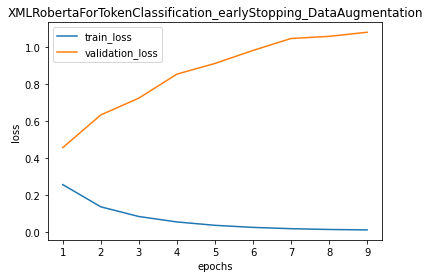

In [25]:
epochs = np.arange(1,epoch+1)
# print(epochs)
plt.plot(epochs,loss_train[:-1],label='train_loss')
plt.plot(epochs,loss_test[:-1],label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('XMLRobertaForTokenClassification_earlyStopping_DataAugmentation')
plt.legend()
plt.show()

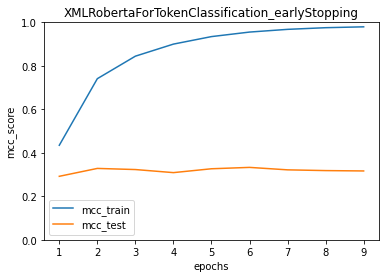

In [26]:
epochs = np.arange(1,epoch+1)
plt.plot(epochs,mcc_score_train[:-1],label='mcc_train')
plt.plot(epochs,mcc_score_test[:-1],label='mcc_test')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.ylim(0.0,1.0)

plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.show()

In [32]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained('xlm-roberta-base')
config.num_labels

2

In [35]:
print('Max mcc achieved for dev data is', np.amax(mcc_score_test),f',in the {np.argmax(mcc_score_test)+1}th epoch ')

Max mcc achieved for dev data is 0.33301352944789897 ,in the 6th epoch 


In [37]:
batch = next(iter(val_dataloader))
input_ids_b = batch[0].cuda()
attention_mask_b = batch[1].cuda()
labels_b = batch[2].cuda()

In [39]:
model.load_state_dict(torch.load('./models/training_data/model_xlmrobertatokenclassificationmodel_DataAugmentationSwap_Combined.bin'))
model.eval()

EntityModel(
  (bert): XLMRobertaForTokenClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_

In [45]:
outputs_pred = model(input_ids_b, attention_mask = attention_mask_b, labels = labels_b )

In [46]:
outputs_pred

(tensor(0.8909, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor([[[-4.3737,  3.5170],
          [-6.3724,  6.3160],
          [-6.4586,  6.3264],
          ...,
          [-4.8733,  4.0834],
          [-4.8733,  4.0834],
          [-4.8733,  4.0834]],
 
         [[-1.7335,  0.9930],
          [-1.7848,  1.4101],
          [-3.4168,  3.6870],
          ...,
          [-1.9491,  1.2468],
          [-1.9491,  1.2468],
          [-1.9491,  1.2468]],
 
         [[-3.7663,  2.9323],
          [-6.2700,  6.2522],
          [-6.2440,  6.1272],
          ...,
          [-4.2845,  3.4959],
          [-4.2845,  3.4959],
          [-4.2845,  3.4959]],
 
         ...,
 
         [[-2.1351,  1.2625],
          [-5.2773,  4.8160],
          [ 0.4509, -0.9331],
          ...,
          [-2.4515,  1.6265],
          [-2.4515,  1.6265],
          [-2.4515,  1.6265]],
 
         [[-4.5004,  3.5977],
          [-5.8598,  5.8037],
          [-6.5245,  6.1573],
          ...,
          [-4.9830,  4.152

In [53]:
labels = labels_b.view(-1) 
active_logits = outputs_pred[1].view(-1, 2)
flattened_predictions = torch.argmax(active_logits, axis=1)
active_accuracy = labels.view(-1) != -100
labels_tmp = torch.masked_select(labels, active_accuracy) 
pred_tmp = torch.masked_select(flattened_predictions, active_accuracy)
print('f1 score for class 0 :',f1_score(labels_tmp.tolist(),pred_tmp.tolist(),average='binary',pos_label = 0))
print('f1 score for class 1 :',f1_score(labels_tmp.tolist(),pred_tmp.tolist(),average='binary',pos_label = 1) )    
print('accuracy score :',accuracy_score(labels_tmp.tolist(),pred_tmp.tolist()))
print('mcc score :',matthews_corrcoef(labels_tmp.tolist(),pred_tmp.tolist()))
print(classification_report(labels_tmp.tolist(),pred_tmp.tolist()))

f1 score for class 0 : 0.3333333333333333
f1 score for class 1 : 0.9270633397312861
accuracy score : 0.8685121107266436
mcc score : 0.2630878770853701
              precision    recall  f1-score   support

           0       0.37      0.30      0.33        63
           1       0.92      0.94      0.93       515

    accuracy                           0.87       578
   macro avg       0.64      0.62      0.63       578
weighted avg       0.86      0.87      0.86       578



In [55]:
print(labels_tmp)
pred_tmp

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,